Name: Layan Alabdullatef

Date: December 3rd, 2023

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import transformers
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

**The full code is available on the github repository:** https://github.com/LayanCS/CXR_Project

In [2]:
# references:
# https://machinelearningmastery.com/deep-learning-caption-generation-models/
# https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3
# https://github.com/cambridgeltl/visual-med-alpaca/tree/2d49088f49da9da7f175165598a1f4beed75961f
# (paper) Show, Attend and Tell https://arxiv.org/pdf/1502.03044v3.pdf
# (paper) GIT: A Generative Image-to-text Transformer for Vision and Language: https://arxiv.org/pdf/2205.14100v5.pdf

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use GPU when available

In [4]:
from google.colab import drive # needed when running the code on Google Colab to access the dataste
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load Dataset

Full code available in the *'data_preparation.ipynb'* notebook

In [5]:
root = '/content/drive/MyDrive/Fall 2023/EE 475/project/UI_chestxray/images/' # path for the images

### Filter the Dataset

I'm filtering the dataset based on the captions (some captions cannot be used) and image view (as each patient has two views and I only need one for the model)

Full code available in the *'data_preparation.ipynb'* notebook

### Prepare the Dataset CSV
* Select only needed columns
* Select a balanced subset of 600 rows (300 from each class normal/abnormal)

Full code available in the *'data_preparation.ipynb'* notebook

In [ ]:
df_data

,index,uid,filename,projection,status,caption
0,0,2,2_IM-0652-1001.dcm.png,Frontal,abnormal,No acute pulmonary findings.
1,1,3,3_IM-1384-1001.dcm.png,Frontal,normal,"No displaced rib fractures, pneumothorax, or p..."
2,2,4,4_IM-2050-1001.dcm.png,Frontal,abnormal,1. Bullous emphysema and interstitial fibrosis...
3,3,5,5_IM-2117-1003002.dcm.png,Frontal,abnormal,No acute cardiopulmonary abnormality.
4,4,6,6_IM-2192-1001.dcm.png,Frontal,normal,No acute cardiopulmonary findings.
...,...,...,...,...,...,...
595,738,912,912_IM-2417-1001.dcm.png,Frontal,normal,1. No acute cardiopulmonary findings.
596,739,913,913_IM-2417-1001.dcm.png,Frontal,normal,Negative for acute cardiopulmonary disease.
597,743,918,918_IM-2420-4004.dcm.png,Frontal,normal,No acute abnormality. .
598,745,920,920_IM-2423-1001.dcm.png,Frontal,normal,No acute cardiopulmonary abnormality.


### Separate into Train and Test

In [ ]:
train_df, test_df = train_test_split(df_data, test_size=0.2) # separate into 80% train, 20% test
# I don't take the class consideration into account here as the number is quite small to make a difference

# include a validation set
train_df, val_df = train_test_split(train_df, test_size=0.13) # 0.13 x 0.8 = 0.10 (10% of the train set)

In [ ]:
# reset the index
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
# save the csv
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')
val_df.to_csv('val_df.csv')

# EDA

In [ ]:
train_df[train_df.status == 'normal'].caption.value_counts() # here we see the captions used with normal images

caption
No acute cardiopulmonary abnormality.                            29
No acute cardiopulmonary disease.                                13
No acute cardiopulmonary abnormalities.                          12
No acute cardiopulmonary process.                                 9
No acute cardiopulmonary findings.                                9
                                                                 ..
Negative for acute cardiopulmonary abnormality.                   1
Normal chest exam.                                                1
Unremarkable examination.                                         1
No acute cardiopulmonary abnormality identified.                  1
No acute cardiopulmonary process. No obvious rib fractures. .     1
Name: count, Length: 85, dtype: int64

In [ ]:
train_df[train_df.status == 'abnormal'].caption.value_counts() # here we see the captions used with abnormal images

caption
No acute cardiopulmonary abnormality.                                                                                                                                                                                                                                                                       14
No active disease.                                                                                                                                                                                                                                                                                           8
No acute disease.                                                                                                                                                                                                                                                                                            7
No acute cardiopulmonary process.                                                  

Although the above captions are for abnormal cases the most common captions are quite similar to normal cases, this could be a challenge for the model. Further, although we selected equal number of samples from each class we can see that there are less captions for normal cases as a lot of the images are using the same caption. In contrast, there are a larger number of captions for the 300 abnormal cases we selected.

In [ ]:
# investigate the size of all the images (to see if i need to resize or apply other preprocessing methods)
size_images = dict()
avg_width = 0
avg_height = 0

for dirpath, _, filenames in os.walk(root):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        if path_image[-3:] == 'png': # to avoid errors
            with Image.open(image) as img:
                width, heigth = img.size
                avg_width += width
                avg_height += heigth
                size_images[path_image] = {'width': width, 'heigth': heigth}

print(f'Average width: {avg_width/len(df_data)}, Average height: {avg_height/len(df_data)}')
print(size_images) # all the w,h values

<BarContainer object of 2 artists>

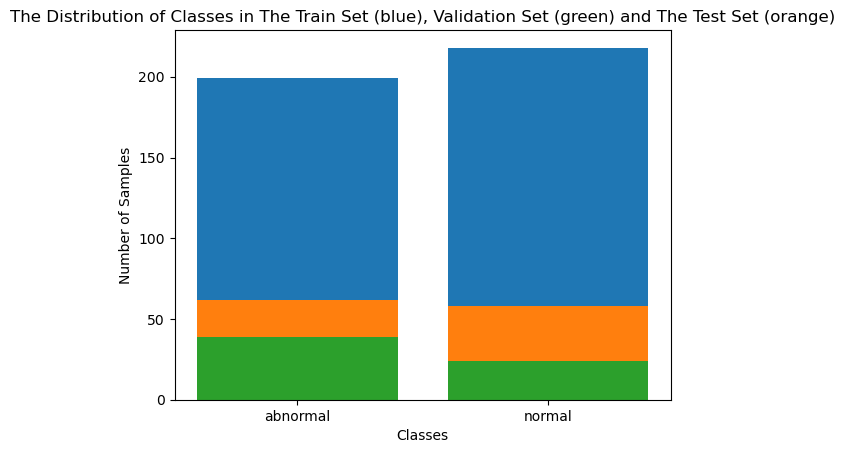

In [ ]:
plt.title('The Distribution of Classes in The Train Set (blue), Validation Set (green) and The Test Set (orange)')
plt.xlabel ('Classes')
plt.ylabel ('Number of Samples')

unique_labels, label_counts = np.unique(train_df.status, return_counts=True)
plt.bar(unique_labels, label_counts)

unique_test_labels, label_test_counts = np.unique(test_df.status, return_counts=True)
plt.bar(unique_test_labels, label_test_counts)

unique_val_labels, label_val_counts = np.unique(val_df.status, return_counts=True)
plt.bar(unique_val_labels, label_val_counts)

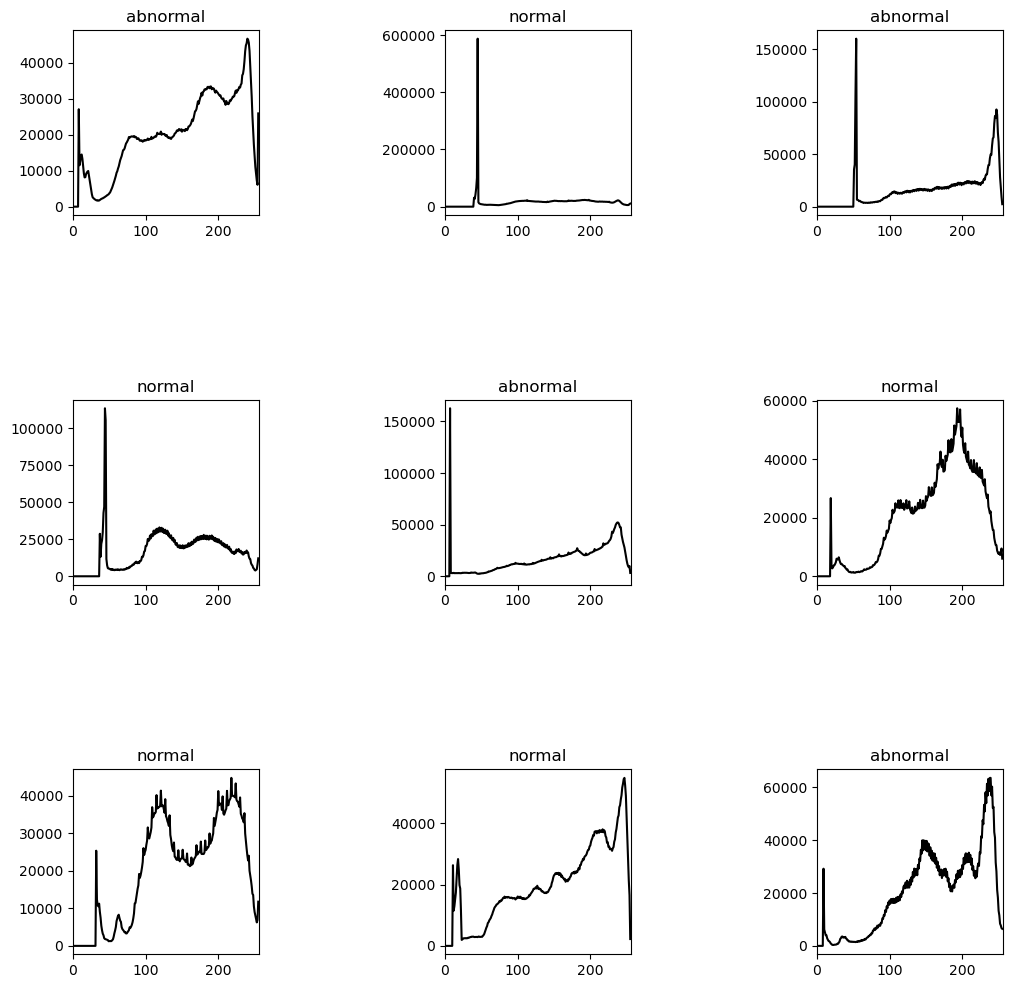

In [ ]:
def showImages_hist_colour(num_row, num_col, dataset):
    '''
    displays the histogram of the pixel values of a sample of images from the train set
    '''
    fig, axes = plt.subplots(num_row, num_col, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(0, num_row * num_col):
        img_path = os.path.join(root, dataset.filename[i])
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = np.asarray(img)
        label = dataset.status[i]

        histogram, bin_edges = np.histogram(
            img, bins=256, range=(0, 256)
        )

        axes[i].set_title("{}".format(label))
        axes[i].plot(bin_edges[0:-1], histogram, color='black')  # Use black color for black and white image
        axes[i].set_xlim([0, 256])
        plt.subplots_adjust(wspace=1, hspace=1)

    plt.show()

    return

showImages_hist_colour(num_row = 3, num_col = 3, dataset = train_df)

from the figure above we can see that the intensity of the pixel values is quite high and differs from each image

# Models

* **classification model:** classifies the images into normal/abnormal using a Convolutional Neural Network
* **image-caption generation:** fine-tune a pretrained model on the images and captions to generate relevant captions given a chest x-ray image

## Classification

### Define the Architecture

In [6]:
## classification model

# Model structure
class ConvNet(nn.Module): # architecture is based on Convolutional Neural Networks (CNNs)
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # first convolutional layer, takes 3 channels (RGB) and outputs 64 channels,
        # the kernel and padding are used to compute the convolutional outputs
        self.relu1 = nn.ReLU() # activation function for the previous layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # second convolutional layer, takes 64 inputs and outputs 128 channels
        self.relu2 = nn.ReLU() # activation function for the previous layer
        self.pool = nn.MaxPool2d(2, 2) # used to reduce computation during the convolutional layers
        self.fc1 = nn.Linear(401408, 512) # first linear layer
        self.relu3 = nn.ReLU() # activation function for the previous layer
        self.fc2 = nn.Linear(512, 2) # second linear layer and last layer of the NN, it has 2 neurons for each class
        # self.sigmoid = nn.Sigmoid()

        # define the loss function
        self.loss = nn.CrossEntropyLoss() # cross-entropy loss for classification

    def forward(self, x):
        '''
        inputs:
            self: class defined values
            x: data point
        outputs:
            x: the value after going through the neural network
        '''
        x = self.relu1(self.conv1(x)) # convolutional layer
        x = self.pool(x) # pooling layer
        x = self.relu2(self.conv2(x)) # convolutional layer
        x = self.pool(x) # pooling layer
        x = torch.flatten(x, start_dim=1) #x.view(-1, 128 * 8 * 8) # flatten the data point (needed for the linear layers)
        x = self.relu3(self.fc1(x)) # linear layer
        x = self.fc2(x) # linear layer and output
        # x = self.sigmoid(x)
        return x

net = ConvNet().to(device) # create an object 'net' of the ConvNet class
# print(net) # print it to see the architecture of the Neural Net

### Load and Preapre the Dataset

In [7]:
## dataset class ##

class df_2_dataset(torch.utils.data.Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): path to the csv file with image filenames and findings/captions
            root_dir (string): directory with all the images
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.image_files = csv_file['filename']
        self.labels = csv_file['status']
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'normal': 0, 'abnormal': 1}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files.iloc[idx])

        image = Image.open(img_name).convert('RGB')
        status = self.labels.iloc[idx]

        # Convert string label to integer label using the mapping
        status_int = self.label_mapping[status]

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': status_int}

        return sample

In [8]:
main = '/content/drive/MyDrive/Fall 2023/EE 475/project/'
train_df = pd.read_csv(main+'train_df.csv')
test_df = pd.read_csv(main+'test_df.csv')
val_df = pd.read_csv(main+'val_df.csv')

In [10]:
# define the parameters
batch_size = 32
num_epochs = 20
# define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # 0.001, 0.01, 0.1

in the cell below, I'm preparing the dataset using a custom class. I'm applying minimal transformation on the image, resize and to tensor. I had to resize the image as the original size was very large. About (2251, 2114) as it is the case with most medical images. However, for the sake of this project and to have it run smoothly on Google Colab I resized the image. Normally for medical data resizing could affect the pixel quality and thus leads to confusion or misclassification.

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_train = df_2_dataset(csv_file=train_df, root_dir=root, transform=transform)
dataset_val = df_2_dataset(csv_file=val_df, root_dir=root, transform=transform)
dataset_test = df_2_dataset(csv_file=test_df, root_dir=root, transform=transform)

In [12]:
train_dataloader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, drop_last=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, drop_last=True)

### Training the Model

In [13]:
### Training Loop ###
print('Begin Training...')

# keep track of the loss and accuracy for both training and validation
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0; correct_train = 0; total_train = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device).long()
        # zero the parameter gradients
        net.zero_grad()
        # Forward pass
        outputs = net(inputs)
        loss = net.loss(outputs, labels) # compute the objective function for the batch
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item() # keep track of the loss during each iteration
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Average validation loss and accuracy for the epoch
    avg_train_loss = running_loss / len(train_dataloader)
    running_accuracy = correct_train / total_train

    # validation phase
    net.eval()  # Set the model to evaluation mode
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs_val, labels_val = data['image'], data['label']
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device).long()
            outputs_val = net(inputs_val)
            loss_val = net.loss(outputs_val, labels_val)
            running_loss_val += loss_val.item()
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    avg_val_loss = running_loss_val / len(val_dataloader)
    running_accuracy_val = correct_val / total_val

    # print the loss after each epoch
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')
    # append accuracy and loss values after each epoch
    training_accuracy.append(running_accuracy)
    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    validation_accuracy.append(running_accuracy_val)

print('Finished Training')

final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print('Final Training Accuracy:', final_training_accuracy) # of the last epoch
print('Final Validation Accuracy:', final_validation_accuracy)

Begin Training...
Epoch 1, Loss: 6.651562887888688
Epoch 2, Loss: 0.6922799899027898
Epoch 3, Loss: 0.6903098729940561
Epoch 4, Loss: 0.6880798018895663
Epoch 5, Loss: 0.6885269834445074
Epoch 6, Loss: 0.6858502122072073
Epoch 7, Loss: 0.6873974066514236
Epoch 8, Loss: 0.6887142887482276
Epoch 9, Loss: 0.6659429944478549
Epoch 10, Loss: 0.7273185711640578
Epoch 11, Loss: 0.6851070890059838
Epoch 12, Loss: 0.6805583788798406
Epoch 13, Loss: 0.6785528017924383
Epoch 14, Loss: 0.6735394046856806
Epoch 15, Loss: 0.6643335360747117
Epoch 16, Loss: 0.6678387201749362
Epoch 17, Loss: 0.6965656097118671
Epoch 18, Loss: 0.6949261472775385
Epoch 19, Loss: 0.6920344187663152
Epoch 20, Loss: 0.68381889966818
Finished Training
Final Training Accuracy: 0.5264423076923077
Final Validation Accuracy: 0.46875


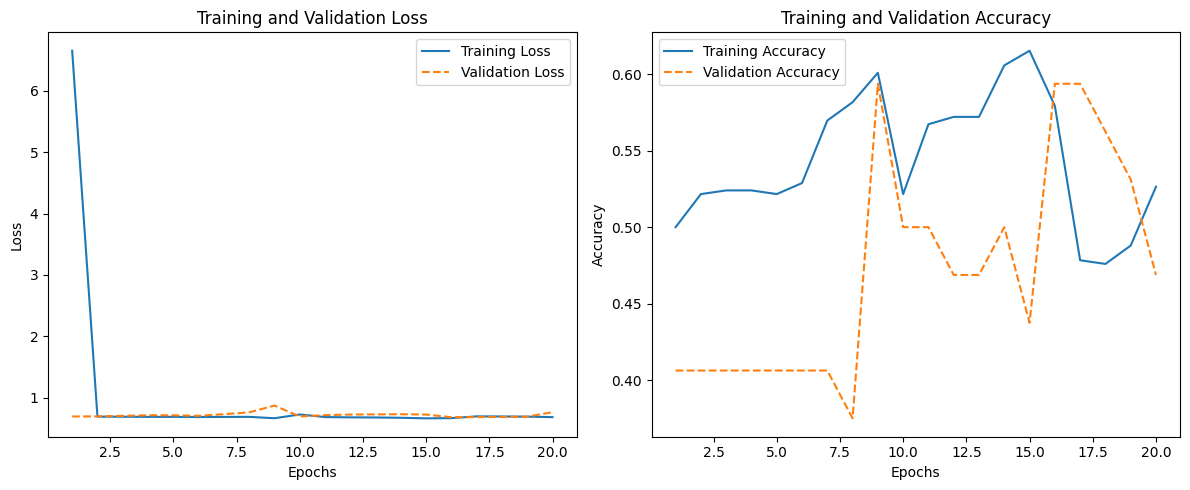

In [14]:
# plot the loss and accuracy we calculated across training
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluate and Test

In [15]:
### Testing Loop ###
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_test = 100 * correct / total
print(f'Accuracy on the test set: {accuracy_test}%')

Accuracy on the test set: 51.041666666666664%


**Observations:**
* With a small batch size (16) and learning rate of 0.001 the model had a hard time converging, reaching less that 60% train accuracy
* Increasing the batch size (32) and the number of epochs (50) results in the loss and train accuracy curves to plateau, reaching 100% train accuracy
* However, despite that the test accuracy still suffers reaching only 52% which is as good as a random guess
* Further, there's a gap between the train and validation loss/accuracy which indicates overfitting
* Yet, increasing the learning rate to 0.01 didn't yield better results, as the model seemed stuck on the same loss value with the test accuracy being 45%
* I believe that resizing the image to 224x224 from the original size contributed greatly to the results as the data became more challenging for the model to classify
* Thus, adding regularization to the model and further transformations to the image might improve the current results

## Image-Caption Generation

### Load and Prepare the Dataset

In [16]:
main = '/content/drive/MyDrive/Fall 2023/EE 475/project/'
train_df = pd.read_csv(main+'train_df.csv')
test_df = pd.read_csv(main+'test_df.csv')
val_df = pd.read_csv(main+'val_df.csv')
# save pretrained model to
output_dir = "/content/drive/MyDrive/Fall 2023/EE 475/project/outputs/"

In [17]:
## dataset class ##

class df_2_dataset_captions(torch.utils.data.Dataset):

    def __init__(self, csv_file, root_dir, processor=None, tokenizer=None, transform=None):
        """
        Args:
            csv_file (string): path to the csv file with image filenames and findings/captions
            root_dir (string): directory with all the images
            processor (callable, optional): to turn each (image, text) pair into the expected inputs
            tokenizer (callable, optional): method of converting a sequence of text into tokens
            transform (callable, optional): optional transform to be applied on a sample
        """
        self.image_files = csv_file['filename']
        self.labels = csv_file['caption']
        self.root_dir = root_dir
        self.transform = transform

        # use `GitProcessor` to turn each (image, text) pair into the expected inputs.
        # the text gets turned into `input_ids` and `attention_mask`, and the image into `pixel_values`
        self.processor = processor
        self.tokenizer = tokenizer # not needed if we use processor
        self.max_text_len = 40

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files.iloc[idx])

        image = Image.open(img_name).convert('RGB') # get the image
        caption = self.labels.iloc[idx] # get the caption

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'caption': caption} # dictionary of image, text pair

        encoding = self.processor(images=sample["image"], text=sample["caption"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [18]:
# bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
transform = transforms.Compose([
    transforms.Resize((224, 224))
    ])

processor = transformers.AutoProcessor.from_pretrained("microsoft/git-base") # processor

dataset_train = df_2_dataset_captions(csv_file=train_df, root_dir=root, processor=processor, transform=transform)
dataset_val = df_2_dataset_captions(csv_file=val_df, root_dir=root, processor=processor, transform=transform)
dataset_test = df_2_dataset_captions(csv_file=test_df, root_dir=root, processor=processor, transform=transform)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

### Define the Model

In [19]:
model = transformers.AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [20]:
model = model.to(device) # move to GPU/CPU

### Training the Model

In [21]:
# create dataloaders, which allows us to get batches of data from the dataset
train_dataloader = DataLoader(dataset_train, shuffle=True, batch_size=4, drop_last=True)
val_dataloader = DataLoader(dataset_val, batch_size=4, drop_last=True)
test_dataloader = DataLoader(dataset_test, batch_size=4, drop_last=True)

In [22]:
### train the model ###

num_epochs = 5
train_loss_history = []
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5) # the optimizer

for epoch in range(num_epochs):
    # print("Epoch:", epoch)
    avg_loss = 0
    with tqdm(total=len(train_dataloader)) as pbar:
        model.train()
        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            attention_mask=batch.pop("attention_mask").to(device)
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            pixel_values=pixel_values,
                            labels=input_ids)
            # forward + backward pass
            loss = outputs.loss
            train_loss_history.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss = (avg_loss * batch_idx + loss.item()) / (batch_idx + 1)
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch}, Loss {loss:.4f}, Avg Loss {avg_loss:.4f}")
    # validation step
    with torch.no_grad():
        model.eval()
        validation_loss = 0
        for batch_idx, batch in enumerate(val_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            loss = outputs.loss
            validation_loss += loss.item()
        validation_loss /= len(val_dataloader)
        print(f"Epoch {epoch}, Validation Loss {validation_loss:.4f}")

Epoch 0, Loss 0.3051, Avg Loss 4.3014: 100%|██████████| 104/104 [01:38<00:00,  1.05it/s]
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0, Validation Loss 0.3910


Epoch 1, Loss 0.0497, Avg Loss 0.1584: 100%|██████████| 104/104 [01:41<00:00,  1.02it/s]


Epoch 1, Validation Loss 0.1524


Epoch 2, Loss 0.0759, Avg Loss 0.0818: 100%|██████████| 104/104 [01:40<00:00,  1.03it/s]


Epoch 2, Validation Loss 0.1311


Epoch 3, Loss 0.0423, Avg Loss 0.0594: 100%|██████████| 104/104 [01:37<00:00,  1.07it/s]


Epoch 3, Validation Loss 0.0925


Epoch 4, Loss 0.0433, Avg Loss 0.0472: 100%|██████████| 104/104 [01:37<00:00,  1.07it/s]


Epoch 4, Validation Loss 0.1369


In [23]:
 # save the model
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)

#### Testing on a random samples

In [29]:
sample_num = np.random.randint(0, len(test_df)) # select random sample
path_img = root + test_df.filename[sample_num] # get the image
image = Image.open(path_img)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=40)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0] # skip special look into
print(generated_caption) # generated caption

1. no acute cardiopulmonary abnormality.


In [30]:
test_df.caption[sample_num] # get the ground-truth caption

'No acute cardiopulmonary abnormality. .'

In [36]:
sample_num = np.random.randint(0, len(test_df)) # select random sample
path_img = root + test_df.filename[sample_num] # get the image
image = Image.open(path_img)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=40)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0] # skip special look into
print(generated_caption) # generated caption

1. no acute cardiopulmonary abnormality.


In [37]:
test_df.caption[sample_num] # get the ground-truth caption

'Heart size normal. Mediastinal silhouette and pulmonary vascularity are within normal limits. There is no focal airspace consolidation, pleural effusion or pneumothorax.'

**Observations:**
* This model is far more complicated than the earlier classifier, it utilizes the attention mechanism and is based on the Transformer model
* Here I fine-tunes the model on 5 epochs
* the model provided good enough results relative to the number of data provided for fine-tuning
* Therefore, I noticed that the model tends to generate normal or healthy reports more